In [1]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

2025-09-08 23:52:27.027570: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Set the default float type to float64


In [2]:
def sir_system(t, compartments, gamma):
    S, I, R = compartments
    return [
        -beta_t(t) * S * I,
        beta_t(t) * S * I - gamma * I,
        gamma * I
    ]

In [3]:
t0, tf = 0, 50
beta_t = lambda x: np.sin(x / ((tf - t0) / (2*np.pi))) * 0.3 + 0.35
# beta_t = lambda x: 0.5 if isinstance(x, float) else np.ones(shape=x.shape) * 0.5
# beta_t = lambda x: np.sin(x / 12) * 0.8 + 0.1
gamma = 0.2 
S0, I0, R0 = 0.99, 0.01, 0.0

In [4]:
sir_sol = solve_ivp(
    sir_system,
    [t0, tf],
    [S0, I0, R0],
    args=[gamma],
    dense_output=True
)

nop_data = 100
train_t = np.linspace(t0, tf, nop_data)
sir_data = sir_sol.sol(train_t).T

In [5]:
# noise_std = 0.02
noise_std = 0.0
sir_data += np.random.normal(scale=noise_std, size=(nop_data, 3))

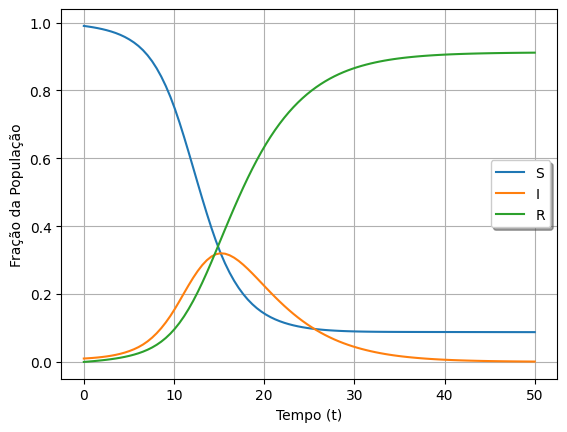

In [6]:
plt.plot(train_t, sir_data)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../images/runge-kutta-predicted-compartiments-sir-nonoise.png")
plt.show()

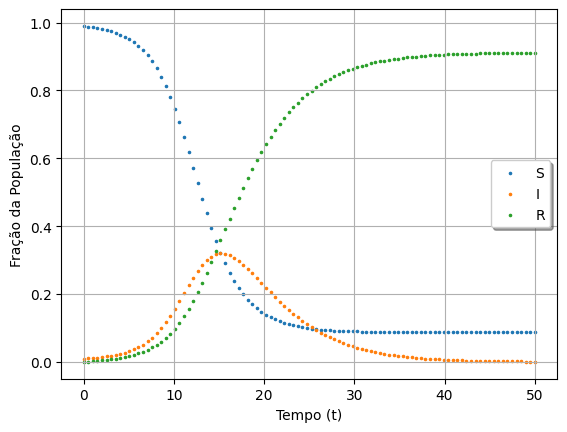

In [7]:
plt.scatter(train_t, sir_data[:, 0], s=2.5)
plt.scatter(train_t, sir_data[:, 1], s=2.5)
plt.scatter(train_t, sir_data[:, 2], s=2.5)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../images/runge-kutta-compartiments-data-sir-nonoise.png")
plt.show()

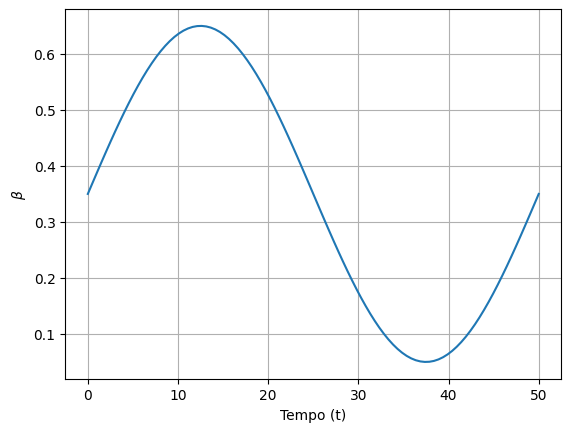

In [8]:

plt.plot(train_t, beta_t(train_t))
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.grid()
plt.savefig("../images/real-beta-sir-nonoise.png")
plt.show()

In [9]:
timeinterval = TimeDomain(t0, tf)

def sir_residual(t, y):
    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]

    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)
    
    return [
        dS_dt + beta * S * I,
        dI_dt - beta * S * I + gamma * I
    ]

# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial
def S0_val(_): return S0
def I0_val(_): return I0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)

data_t = train_t.reshape(-1, 1)
data_S = PointSetBC(data_t, sir_data[:,0:1], component=0)
data_I = PointSetBC(data_t, sir_data[:,1:2], component=1)

ics = [ic_S, ic_I]
data_conds = [
    # data_S,
    data_I 
] 

conditions = ics + data_conds

data = PDE(
    timeinterval, 
    sir_residual, 
    conditions,
    num_domain=128,
    num_boundary=2,
    num_test=32,
    anchors=data_t
)

n_hidden_layers = 4
hidden_layer_size = 50
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
# activation = ["tanh"] * n_hidden_layers + ["sigmoid"]
activation = "tanh"
# activation = "ReLU"
initializer = "Glorot normal"
optimizer = "adam"
lr = 0.002

eq_w = 10
ic_w = 10
data_w = 1

loss_weights = [eq_w] * 2 + [ic_w] * len(ics) + [data_w] * len(data_conds)

net = FNN(
    topology, 
    activation, 
    initializer
)

# net = PFNN(
#     topology, 
#     activation, 
#     initializer
# )

model = Model(data, net)

model.compile(
    optimizer, 
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.051261 s



2025-09-08 23:52:39.512361: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1757386359.513100   75065 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1799 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
early_stopping = EarlyStopping(min_delta=1e-5, patience=5000)

losshistory, train_state = model.train(
    iterations=150000, 
    display_every=100,
    # callbacks=[early_stopping]
)

model.compile(
    "L-BFGS", 
    loss_weights=loss_weights
)

dde.optimizers.set_LBFGS_options(
    # ftol=np.finfo(float).eps,
    maxiter=25000,
    ftol=1e-10,
    gtol=1e-12
)

losshistory, train_state = model.train(
    iterations=20000, 
    display_every=100
)

Training model...



2025-09-08 23:52:42.327214: I external/local_xla/xla/service/service.cc:163] XLA service 0x557622d47b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-08 23:52:42.327233: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-09-08 23:52:42.335495: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-08 23:52:42.397632: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1757386362.702043   75065 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric
0         [5.38e-03, 7.75e-02, 9.80e+00, 1.00e-03, 1.69e-01]    [4.84e-03, 7.47e-02, 9.80e+00, 1.00e-03, 1.69e-01]    []  
100       [2.71e-04, 3.22e-04, 8.08e-07, 1.38e-05, 2.50e-03]    [1.23e-04, 3.25e-04, 8.08e-07, 1.38e-05, 2.50e-03]    []  
200       [2.20e-04, 2.88e-04, 2.34e-09, 1.57e-08, 1.75e-03]    [1.01e-04, 2.83e-04, 2.34e-09, 1.57e-08, 1.75e-03]    []  
300       [1.85e-04, 1.99e-04, 5.37e-09, 6.50e-09, 1.43e-03]    [7.34e-05, 1.97e-04, 5.37e-09, 6.50e-09, 1.43e-03]    []  
400       [1.68e-04, 1.35e-04, 5.62e-09, 1.75e-09, 1.17e-03]    [6.73e-05, 1.34e-04, 5.62e-09, 1.75e-09, 1.17e-03]    []  
500       [1.52e-04, 9.29e-05, 5.43e-09, 2.23e-12, 9.66e-04]    [6.34e-05, 9.36e-05, 5.43e-09, 2.23e-12, 9.66e-04]    []  
600       [1.36e-04, 6.69e-05, 4.90e-09, 1.19e-09, 7.99e-04]    [5.83e-05, 6.79e-05, 4.90e-09, 1.19e-09, 7.99e-04]    []  
700      

In [11]:
model.save("../models/sir-nonoise")

'../models/sir-nonoise-175000.weights.h5'

In [12]:
dde.saveplot(
    losshistory, 
    train_state, 
    issave=True, 
    isplot=False,
    output_dir="../losses", 
    loss_fname=f"loss-sir-nonoise",
    train_fname=f"train-sir-nonoise",
    test_fname=f"test-sir-nonoise")

Saving loss history to ../losses/loss-sir-nonoise ...
Saving training data to ../losses/train-sir-nonoise ...
Saving test data to ../losses/test-sir-nonoise ...


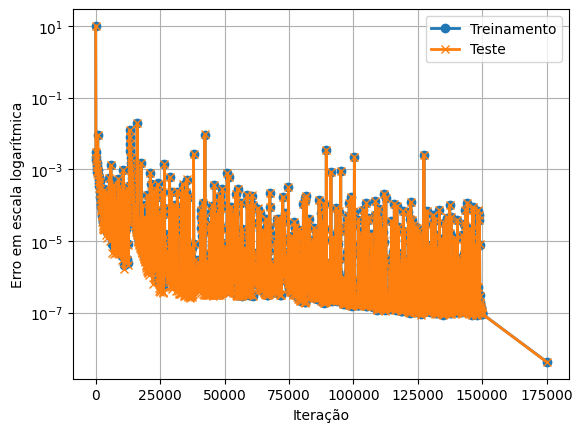

In [13]:
train = np.sum(losshistory.loss_train, axis=1)
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, train, "o-", label="Treinamento", linewidth=2)
plt.semilogy(losshistory.steps, test, "x-", label="Teste", linewidth=2)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
plt.savefig(f"../images/sir-loss-nonoise.png")
plt.show()

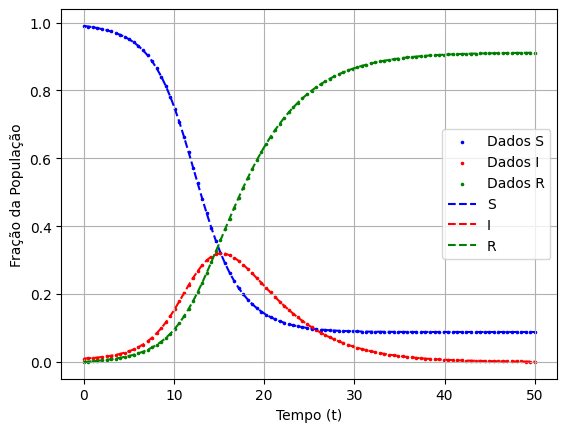

In [14]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t0, tf, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

S_pred, I_pred = y_pred[:, 0], y_pred[:, 1]
R_pred = 1 - S_pred - I_pred  

plt.scatter(train_t, sir_data[:,0], label="Dados S", color="blue", s=2.5)
plt.scatter(train_t, sir_data[:,1], label="Dados I", color="red", s=2.5)
plt.scatter(train_t, sir_data[:,2], label="Dados R", color="green", s=2.5)

plt.plot(test_t, S_pred, label="S", linestyle="--", color="blue")
plt.plot(test_t, I_pred, label="I", linestyle="--", color="red")
plt.plot(test_t, R_pred, label="R", linestyle="--", color="green")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()
plt.savefig("../images/predicted-compartments-sir-nonoise.png")

plt.show()

[]

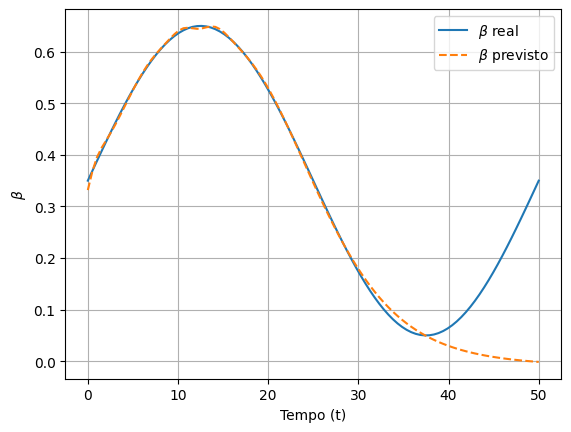

In [15]:
beta_pred = y_pred[:, 2]
beta_real = beta_t(test_t)
plt.plot(test_t, beta_real, label=r"$\beta$ real")
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.savefig("../images/predicted-beta-sir-nonoise.png")
plt.plot()

In [16]:
sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = 1 - S_real - I_real

### MSE

In [17]:
mean_squared_error(S_real, S_pred)

2.8591716237654474e-08

In [18]:
mean_squared_error(I_real, I_pred)

3.0797673645368704e-09

In [19]:
mean_squared_error(R_real, R_pred)

2.0734955202071848e-08

In [20]:
mean_squared_error(beta_real, beta_pred)

0.008461893216107066